In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
from numpy.linalg import inv
%matplotlib inline

In [137]:
data = pd.read_csv("data/Portfolios_Formed_on_INV-2.csv",skiprows=17,index_col=0,parse_dates=True,nrows=691) 
data = data.dropna()
data.index = pd.to_datetime(data.index,format="%Y%m")

factors = pd.read_csv("data/F-F_Research_Data_Factors.csv",skiprows=3,index_col=0,parse_dates=True,nrows=1134) 
factors = factors.dropna()
factors.index = pd.to_datetime(factors.index,format="%Y%m")
rm = factors["Mkt-RF"]
rf = factors["RF"]

portfolio_25 = pd.read_csv("data/25_Portfolios_5x5.csv",skiprows=15,index_col="DATE",parse_dates=True,nrows=1134) 
portfolio_25 = portfolio_25.dropna()
portfolio_25.index = pd.to_datetime(portfolio_25.index,format="%Y%m")

portfolio_25 = portfolio_25["1963-07-01":"2020-06-01"]
data = data["1963-07-01":"2020-06-01"]
rm = rm["1963-07-01":"2020-06-01"]
rf = rf["1963-07-01":"2020-06-01"]
factors = factors["1963-07-01":"2020-06-01"]
ex_data = data.subtract(rf,axis=0)
portfolio_25_excess = portfolio_25.sub(rf,axis=0)
factors = factors.drop("RF",axis=1)

In [150]:
factors_inv

,Mkt-RF,SMB,HML,INV
1963-07-01,-0.39,-0.56,-0.83,1.35
1963-08-01,5.07,-0.94,1.67,0.02
1963-09-01,-1.57,-0.30,0.18,0.53
1963-10-01,2.53,-0.54,-0.10,4.58
1963-11-01,-0.85,-1.13,1.71,-2.67
...,...,...,...,...
2020-02-01,-8.13,1.00,-3.96,2.48
2020-03-01,-13.38,-5.10,-14.11,-1.62
2020-04-01,13.65,2.75,-1.35,2.76
2020-05-01,5.58,2.47,-4.95,2.63


In [151]:
# b, CAPM for the 10 investment portfolios, plot alphas against investment deciles
alphas = []
betas = []
for i in range(8,18):
    y = ex_data.iloc[:,i]
    x = sm.add_constant(rm)
    res = sm.OLS(y,x,cov_type="HC0").fit()
    alphas.append(res.params[0])
    betas.append(res.params[1])

alphas = pd.DataFrame(alphas).T
alphas.columns = ["Lo 10","Dec 2", "Dec 3","Dec 4","Dec 5", "Dec 6", "Dec 7","Dec 8", "Dec 9", "Hi 10"]
alphas.index = ["Pricing error"]
alphas = alphas.T

In [152]:
alphas

,Pricing error
Lo 10,0.167358
Dec 2,0.233005
Dec 3,0.185294
Dec 4,0.103203
Dec 5,0.090755
Dec 6,0.051453
Dec 7,0.115504
Dec 8,-0.010789
Dec 9,0.022597
Hi 10,-0.321981


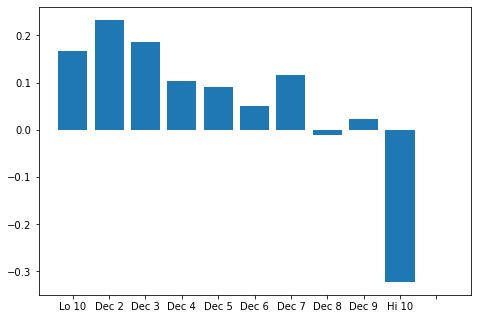

In [153]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["Lo 10","Dec 2" ,"Dec 3","Dec 4","Dec 5", "Dec 6", "Dec 7","Dec 8", "Dec 9", "Hi 10",""]
a = [alphas.iloc[0],alphas.iloc[1],alphas.iloc[2],alphas.iloc[3],alphas.iloc[4],alphas.iloc[5],alphas.iloc[6],alphas.iloc[7],alphas.iloc[8],alphas.iloc[9],0]
ax.bar(langs,a)
plt.show()


In [154]:
inv_growth = data["Hi 30"] - data["Lo 30"]
factors_inv = factors.copy()
factors_inv["INV"] = inv_growth

In [155]:
def calc_GRS(alpha_vector, factor_dataframe, asset_returns):
    gen_cov = factor_dataframe.cov()
    generalized_sharpe = factor_dataframe.mean().T @ inv(gen_cov) @ factor_dataframe.mean()     #Cochrane 2005, p.217
    cov = asset_returns.cov()
    if isinstance(alpha_vector, list):
        alpha_vector = np.array(alpha_vector)
    #Calc GRS
    df = len(asset_returns) - len(asset_returns.columns) - len(factor_dataframe.columns) # T - N - K     (N = number of assets, K = number of factors)
    N = len(asset_returns.columns)
    GRS = (df/ N) * ((alpha_vector.T @ inv(cov) @ alpha_vector) / (1+ generalized_sharpe))
    p = 1-scipy.stats.f.cdf(GRS, len(asset_returns.columns), df) #find p-value of F test statistic
    return GRS, p

In [140]:
# 3 d

inv_alphas = []
inv_tvalues = []
inv_adj_rsq = []

for column in portfolio_25_excess:
    x = sm.add_constant(factors_inv)
    y = portfolio_25_excess[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    inv_alphas.append(res.params[0])
    inv_tvalues =  res.params / x.std()
    inv_tvalues.append(res.tvalues)
    inv_adj_rsq.append(res.rsquared_adj)

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BIG HiBM   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     681.0
Date:                Thu, 04 Feb 2021   Prob (F-statistic):          6.14e-236
Time:                        17:48:54   Log-Likelihood:                -1593.8
No. Observations:                 684   AIC:                             3198.
Df Residuals:                     679   BIC:                             3220.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1663      0.097     -1.712      0.087      -0.357       0.024
Mkt-RF         1.1096      0.024     46.696      0.000       1.063       1.156
SMB           -0.1614      0.033     -4.858      0.000      -0.227      -0.096
HML            0.9208      0.044     21.106      0.000       0.835       1.006
INV            0.1705      0.052      3.297      0.001       0.069       0.272
==============================================================================
Omnibus:                      146.236   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              987.695
Skew:                          -0.769   Prob(JB):                    3.35e-215
Kurtosis:                       8.683   Cond. No.                         4.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
# 3 d investment farma french model

inv_alphas = []
inv_tvalues = []
inv_adj_rsq = []

for column in portfolio_25_excess:
    x = sm.add_constant(factors_inv)
    y = portfolio_25_excess[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    inv_alphas.append(res.params[0])
    inv_tvalues.append(res.tvalues)
    inv_adj_rsq.append(res.rsquared_adj)


grs_a = inv_alphas
ff_investment_table = pd.DataFrame(inv_tvalues)
inv_alphas = pd.DataFrame(inv_alphas)
inv_alphas.columns = ["alphas"]
inv_adj_rsq = pd.DataFrame(inv_adj_rsq)
inv_adj_rsq.columns = ["Adjusted R Squared"]
ff_investment_table["Alphas"] = inv_alphas
ff_investment_table["Adjusted R^2"] = inv_adj_rsq
ff_investment_table.columns = ["Alpha tval", "Mkt-RF tval","SMB tval","HML tval", "INV tval","Alphas","Adj R^2"]
ff_investment_table.index = portfolio_25.columns
ff_investment_table.round(2)

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,INV tval,Alphas,Adj R^2
SMALL LoBM,-5.06,48.77,43.72,-6.47,1.14,-0.46,0.91
ME1 BM2,0.26,54.60,52.97,0.85,0.13,0.02,0.93
ME1 BM3,-0.50,74.57,61.80,12.90,-0.30,-0.03,0.95
ME1 BM4,2.77,70.87,61.91,20.51,0.57,0.14,0.95
SMALL HiBM,2.42,71.72,58.23,28.68,1.01,0.13,0.95
ME2 BM1,-2.98,72.56,45.43,-12.98,-0.80,-0.19,0.95
ME2 BM2,0.06,77.47,48.75,2.55,-3.68,0.00,0.95
ME2 BM3,1.28,70.42,37.60,13.74,-2.47,0.07,0.93
ME2 BM4,0.92,81.97,44.26,24.45,-2.75,0.04,0.95
ME2 BM5,-0.40,84.49,49.58,34.03,1.24,-0.02,0.95


In [173]:
averages_inv = ff_investment_table.mean()
averages_inv =  pd.DataFrame(averages_inv).T
averages_inv.index = ["Averages"]
averages_inv

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,INV tval,Alphas,Adj R^2
Averages,-0.091025,69.857458,25.470983,9.555934,-1.393402,-0.021031,0.915376


In [160]:
ff_table.mean()

Alpha tval      0.000869
Mkt-RF tval    71.441837
SMB tval       25.411070
HML tval       13.170565
Alphas         -0.015458
Adj R^2         0.913864
dtype: float64

In [159]:
ff_alphas = []
ff_tvalues = []
ff_adj_rsq = []

for column in portfolio_25_excess:
    x = sm.add_constant(factors)
    y = portfolio_25_excess[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    ff_alphas.append(res.params[0])
    ff_tvalues.append(res.tvalues)
    ff_adj_rsq.append(res.rsquared_adj)

grs_b = ff_alphas
ff_table = pd.DataFrame(ff_tvalues)
ff_alphas = pd.DataFrame(ff_alphas)
ff_alphas.columns = ["alphas"]
ff_adj_rsq = pd.DataFrame(ff_adj_rsq)
ff_adj_rsq.columns = ["Adjusted R Squared"]
ff_table["Alphas"] = ff_alphas
ff_table["Adjusted R^2"] = ff_adj_rsq
ff_table.columns = ["Alpha tval", "Mkt-RF tval","SMB tval","HML tval","Alphas","Adj R^2"]
ff_table.index = portfolio_25.columns
ff_table.round(2)

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,Alphas,Adj R^2
SMALL LoBM,-5.15,50.84,43.75,-9.11,-0.47,0.91
ME1 BM2,0.25,56.65,53.02,0.99,0.02,0.93
ME1 BM3,-0.48,77.25,61.85,16.63,-0.02,0.95
ME1 BM4,2.74,73.63,61.96,25.63,0.14,0.95
SMALL HiBM,2.36,74.60,58.27,35.64,0.13,0.95
ME2 BM1,-2.94,74.99,45.43,-15.87,-0.19,0.95
ME2 BM2,0.31,78.56,48.24,6.07,0.02,0.95
ME2 BM3,1.44,72.04,37.42,19.31,0.08,0.93
ME2 BM4,1.10,83.79,44.00,33.06,0.05,0.95
ME2 BM5,-0.49,87.85,49.60,42.24,-0.03,0.95


In [161]:
# GRS and p values for ff and investment
inv_GRS, inv_p = calc_GRS(grs_a,factors_inv,portfolio_25)
inv_GRS, inv_p

(3.563215755308802, 1.8629551679083534e-08)

In [162]:
# GRS and p values for ff alone
ff_GRS, ff_p = calc_GRS(grs_b,factors,portfolio_25)
ff_GRS, ff_p

(3.4702875417798045, 3.994868091883319e-08)